# Currents in the Haldane model

In [1]:
import numpy as np
from scipy.linalg import eigh

from lattice import OpenLattice
from hamiltonian import OpenHamiltonian
from harmonic_trap import build_harmonic_trap
from currents import compute_currents
from plot_lattice import plot_voronoi, plot_scatter

## Hamiltonian parameters

Hamiltonian:

$$ H = t_1 \sum_{\langle ij\rangle} a^\dagger_i a_j + t_2 \sum_{\langle\langle ij\rangle\rangle} e^{i\phi_{ij}} a^\dagger_i a_j $$

In [2]:
Nx = Ny = 25
Np = int(Nx*Ny*0.8)
lattice = OpenLattice(Nx, Ny, Np)
t1 = 1
t2 = 0.1
dphi = 0.5
hopping_params = (t1, t2, dphi)
hoppings_type = 'haldane'
single_levels = build_harmonic_trap(lattice, 1/30)
ham = OpenHamiltonian(lattice, single_levels,
                      hopping_params, hoppings_type)
print(f'Number of sites = {lattice.L}')
print(f'Number of particles = {lattice.Np}')

Number of sites = 1350
Number of particles = 500


## Hamiltonian diagonalization

In [3]:
w, v = eigh(ham.J)
v = v[:, :Np]

## Occupation numbers


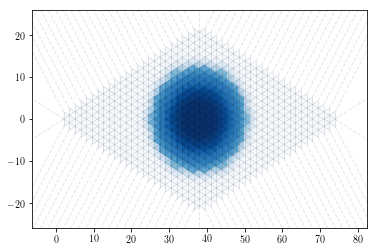

In [4]:
occupations = np.linalg.norm(v, axis=1)
plot_voronoi(lattice, occupations)

## Currents

The time variation of the occupation number is
$$ J_i = -i\left[n_i,\ H\right] = -i\left(\sum_j e^{i\vec{p}\cdot\vec{v}}\ a^\dagger_i a_{i+j} - e^{-i\vec{p}\cdot\vec{v}}\ a^\dagger_{i+j} a_i\right) = 2\sum_j \textit{Im}\left(e^{i\vec{p}\cdot\vec{v}}\ a^\dagger_i a_{i+j}\right)$$

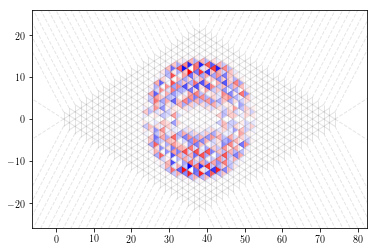

In [5]:
currents = compute_currents(lattice, ham.J, v)
plot_voronoi(lattice, currents, 'bwr')